<h1>Strawberries vs Raspberries</h2>
<h3>Notebook Execution Time: 13 minutes</h3>

<h4>Additional Library</h4>
<blockquote>pip install opencv-python</blockquote>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Flatten

from tensorflow import py_function

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomTranslation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet152_preprocess_input

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess_input

from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as eff_preprocess_input

<h1>Load Dataset</h1>

In [2]:
base_dir = "./"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [3]:
train_dataset = image_dataset_from_directory(directory=train_dir, label_mode="binary", image_size=(224, 224))
val_dataset = image_dataset_from_directory(directory=val_dir, label_mode="binary", image_size=(224, 224))
test_dataset = image_dataset_from_directory(directory=test_dir, label_mode="binary", image_size=(224, 224))

Found 100 files belonging to 2 classes.
Found 50 files belonging to 2 classes.
Found 50 files belonging to 2 classes.


<h1>Sample Convolutional Network</h1>
<p>This is a simple convolutional network to see how much of an improvement we will gain from transfer learning!</p>
<p> I will evalute this on the test dataset at the end and compare to my model that uses transfer learning</p>

In [4]:
inputs = Input(shape=(224, 224, 3))
x = Rescaling(scale=1./255)(inputs)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=128, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=64, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation="relu")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
basic_model = Model(inputs, outputs)
basic_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

<h3>Fit the model</h3>

In [5]:
basic_model_results = basic_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)],
                verbose=0)

2023-02-01 14:31:25.068873: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


<AxesSubplot: >

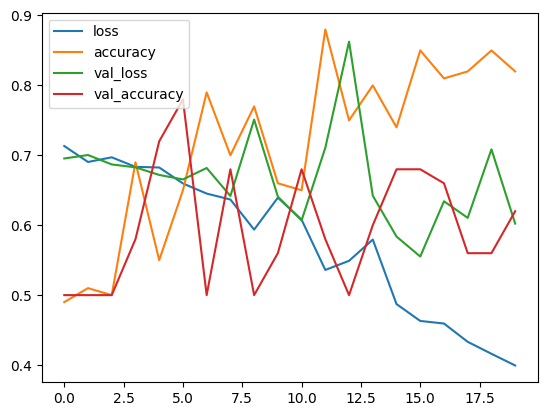

In [6]:
pd.DataFrame(basic_model_results.history).plot()

<p>This graph is very reactive, this is to be expected as we have a pretty small dataset and this classification doesn't have obvious features to distinguish one another e.g if we had apple vs orange, the colour would be what it learns as a dominant feature</p>
<p>We are also using very little examples which is where transfer learning will come into play to mitigate this problem.</p>

<h1>Efficient Net V2 Medium</h1>
<p>I used this <a href="https://keras.io/api/applications/">page</a> to look at the various models that Keras has to offer.</p> 
<p>Efficient Net V2M seemed to have very nice accuracy without having an absurd amount of parameters.</p>

>I tried ResNet50, Inception and VGG16 during my testing but only saw a good improvement by using EfficientNet.

<h3>Import Transfer Model</h3>

In [21]:
eff_base = EfficientNetV2M(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

<h3>Adding the EfficientNet Base Model</h3>
<p>Pre process the input for the efficient base model using the efficient preprocess input method.</p>

In [22]:
inputs = Input(shape=(224, 224, 3))
x = eff_preprocess_input(inputs)
x = eff_base(x)
x = Flatten()(x)
outputs = Dense(1, activation="sigmoid")(x)
eff_model = Model(inputs=inputs, outputs=outputs)

<h3>Freeze the weights of the base to keep the originally learned weights</h3>

In [23]:
eff_base.trainable = False

<h3>Compile & Fit</h3>

In [24]:
eff_model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

<p>During my fit method, I use a patience of 10 rather than 4 that was used before. This is because my model would sometimes get stuck in a local minimum. Changing this helped it reached a lower validation error which is what I want. You will notice the training accuracy will be 1.0 during some of the epochs but we are aiming for the lowest validation loss to ensure we have a good chance of getting better accuracy on unseen (test) data.</p>

<p>I also use verbose 2 to get a detailed report on every epoch.</p>

> Read these parameters from <a href="https://keras.io/api/callbacks/early_stopping/">here</a>

In [25]:
eff_model_history = eff_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
                verbose=2)

Epoch 1/30
4/4 - 17s - loss: 0.6945 - accuracy: 0.6300 - val_loss: 0.5494 - val_accuracy: 0.7600 - 17s/epoch - 4s/step
Epoch 2/30
4/4 - 7s - loss: 0.5177 - accuracy: 0.7700 - val_loss: 0.4465 - val_accuracy: 0.8400 - 7s/epoch - 2s/step
Epoch 3/30
4/4 - 7s - loss: 0.3866 - accuracy: 0.8500 - val_loss: 0.5415 - val_accuracy: 0.6800 - 7s/epoch - 2s/step
Epoch 4/30
4/4 - 7s - loss: 0.3797 - accuracy: 0.8500 - val_loss: 0.6498 - val_accuracy: 0.6000 - 7s/epoch - 2s/step
Epoch 5/30
4/4 - 7s - loss: 0.4208 - accuracy: 0.8000 - val_loss: 0.4256 - val_accuracy: 0.8200 - 7s/epoch - 2s/step
Epoch 6/30
4/4 - 6s - loss: 0.2601 - accuracy: 0.9500 - val_loss: 0.4348 - val_accuracy: 0.7600 - 6s/epoch - 2s/step
Epoch 7/30
4/4 - 7s - loss: 0.3043 - accuracy: 0.8800 - val_loss: 0.7474 - val_accuracy: 0.5400 - 7s/epoch - 2s/step
Epoch 8/30
4/4 - 6s - loss: 0.3509 - accuracy: 0.8400 - val_loss: 0.3249 - val_accuracy: 0.8600 - 6s/epoch - 2s/step
Epoch 9/30
4/4 - 6s - loss: 0.2044 - accuracy: 0.9500 - val_lo

<h3>Displaying the graph</h3>
<p>The graph looks a lot better from before and you can tell our validation accuracy has increased!</p>

<AxesSubplot: >

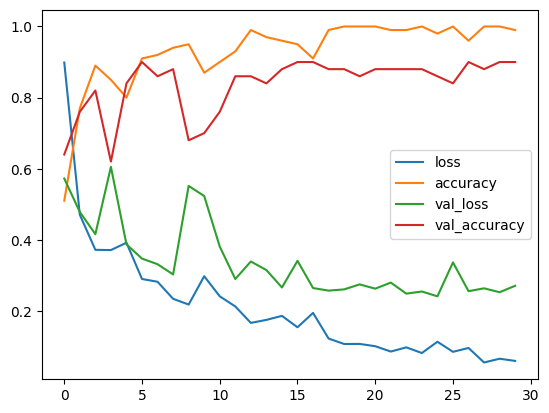

In [12]:
pd.DataFrame(eff_model_history.history).plot()

<h3>Get the Validation Error and Accuracy</h3>
<p> I just evalute on the validation dataset to see what our final val accuracy and loss is. There is probably a better way to do this and get it from the history. </p>

In [ ]:
val_loss, val_acc = eff_model.evaluate(val_dataset)
print("Validation Loss: %s | Validation Accuracy %s" % (val_loss, val_acc))

<h3>Underfitting!</h3>
<p>Obviously we are going to be underfitting. This is because the EfficientNet wasn't trained to learn what a strawberry is and what a raspberry is. Also looking at the graph we can clearly see we are underfitting.</p> 
<p>Gathering more examples won't do anything in this model. Meaning augmentation will not help as it isn't an issue with lack of examples.</p>
<p>Lets try add more layers because more layers means more weights and more weights means more specificity!... hopefully.</p>

<h1>Adding more layers!</h1>
<p>Instead of flattening the tensor to a one dimensional tensor, I use GlobalAveragePooling2D layer to get the average pooling between spatial tensors until each tensor is 1. It is used for spatial data. I thought this would be better in this scenario for this dataset. This layer is then fed into a dense layer that eventually goes to one output.</p>
<a href = "https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D"> https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D</a>

<a href="https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras">https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras</a>

In [94]:
eff_base = EfficientNetV2M(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [95]:
inputs = Input(shape=(224, 224, 3))
x = eff_preprocess_input(inputs)
x = eff_base(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
outputs = Dense(1, activation="sigmoid")(x)
eff_model = Model(inputs=inputs, outputs=outputs)

<h2>Repeat everything again</h2>

In [96]:
eff_base.trainable = False

<p>I lowered the learning rate so it gets closer to the minimum instead of bouncing around.</p>

In [97]:
eff_model.compile(optimizer=RMSprop(learning_rate=0.00003), loss="binary_crossentropy", metrics=["accuracy"])

In [98]:
eff_model_history = eff_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
                verbose=2)

Epoch 1/30
4/4 - 18s - loss: 0.6936 - accuracy: 0.5400 - val_loss: 0.6519 - val_accuracy: 0.6600 - 18s/epoch - 5s/step
Epoch 2/30
4/4 - 6s - loss: 0.6475 - accuracy: 0.6400 - val_loss: 0.6274 - val_accuracy: 0.8200 - 6s/epoch - 2s/step
Epoch 3/30
4/4 - 6s - loss: 0.6252 - accuracy: 0.8100 - val_loss: 0.6094 - val_accuracy: 0.8200 - 6s/epoch - 2s/step
Epoch 4/30
4/4 - 6s - loss: 0.6027 - accuracy: 0.8300 - val_loss: 0.5972 - val_accuracy: 0.8400 - 6s/epoch - 2s/step
Epoch 5/30
4/4 - 6s - loss: 0.5973 - accuracy: 0.8700 - val_loss: 0.5824 - val_accuracy: 0.8200 - 6s/epoch - 2s/step
Epoch 6/30
4/4 - 6s - loss: 0.5846 - accuracy: 0.8700 - val_loss: 0.5697 - val_accuracy: 0.8600 - 6s/epoch - 2s/step
Epoch 7/30
4/4 - 6s - loss: 0.5695 - accuracy: 0.8800 - val_loss: 0.5590 - val_accuracy: 0.8800 - 6s/epoch - 2s/step
Epoch 8/30
4/4 - 6s - loss: 0.5681 - accuracy: 0.8400 - val_loss: 0.5491 - val_accuracy: 0.8600 - 6s/epoch - 2s/step
Epoch 9/30
4/4 - 6s - loss: 0.5525 - accuracy: 0.8800 - val_lo

In [99]:
val_loss, val_acc = eff_model.evaluate(val_dataset)
print("Validation Loss: %s | Validation Accuracy %s" % (val_loss, val_acc))

2/2 [==============================] - 2s 749ms/step - loss: 0.3838 - accuracy: 0.9200
Validation Loss: 0.383750319480896 | Validation Accuracy 0.9200000166893005


<h3>Improvement</h3>
<p>By just adding more layers and changing the learning rate we get lower loss, although you might not because of the random weight initialization. I could have changed the epochs to ensure the lowest loss is found but it would take too long to run.</p>
<p>If I add more layers then my accuracy may improve or I will start to overfit. My goal isn't to get the best accuracy and see how many layers work best (I could sit here all day doing this to find the best model).  It is just to show an improvement from adding a base to a transfered model (showing how a transfer model can be used for more specific tasks). Also I would like something to talk about in my demo instead of 100% accuracy on the test set.</p>

<h3>Unfreezing the Convolutional Base</h3>
<p>Now we will unfreeze the convolutional base to try and adjust those weights to try get more specific to the current task.</p>
<p>The BatchNormalization layers will not be trainable because we don't want our new network to learn new batch normalization parameters on our examples, we want to keep the optimized ones that were created from the original examples that were used when the base model was made.</p>

In [100]:
for layer in eff_base.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

In [101]:
eff_model.compile(optimizer=RMSprop(learning_rate=0.00003), loss="binary_crossentropy", metrics=["accuracy"])

In [102]:
eff_model_history = eff_model.fit(train_dataset, epochs=30, 
                validation_data=val_dataset, 
                callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)],
                verbose=2)

Epoch 1/30
4/4 - 17s - loss: 0.3659 - accuracy: 0.9000 - val_loss: 0.3722 - val_accuracy: 0.8800 - 17s/epoch - 4s/step
Epoch 2/30
4/4 - 6s - loss: 0.3415 - accuracy: 0.9400 - val_loss: 0.3634 - val_accuracy: 0.9000 - 6s/epoch - 2s/step
Epoch 3/30
4/4 - 6s - loss: 0.3485 - accuracy: 0.8800 - val_loss: 0.3614 - val_accuracy: 0.9200 - 6s/epoch - 2s/step
Epoch 4/30
4/4 - 6s - loss: 0.3419 - accuracy: 0.8800 - val_loss: 0.3584 - val_accuracy: 0.9000 - 6s/epoch - 2s/step
Epoch 5/30
4/4 - 6s - loss: 0.3264 - accuracy: 0.9100 - val_loss: 0.3515 - val_accuracy: 0.9000 - 6s/epoch - 2s/step
Epoch 6/30
4/4 - 6s - loss: 0.3232 - accuracy: 0.9400 - val_loss: 0.3488 - val_accuracy: 0.9200 - 6s/epoch - 2s/step
Epoch 7/30
4/4 - 6s - loss: 0.3338 - accuracy: 0.9100 - val_loss: 0.3475 - val_accuracy: 0.9000 - 6s/epoch - 2s/step
Epoch 8/30
4/4 - 6s - loss: 0.3124 - accuracy: 0.9200 - val_loss: 0.3411 - val_accuracy: 0.9200 - 6s/epoch - 2s/step
Epoch 9/30
4/4 - 6s - loss: 0.3123 - accuracy: 0.9000 - val_lo

<AxesSubplot: >

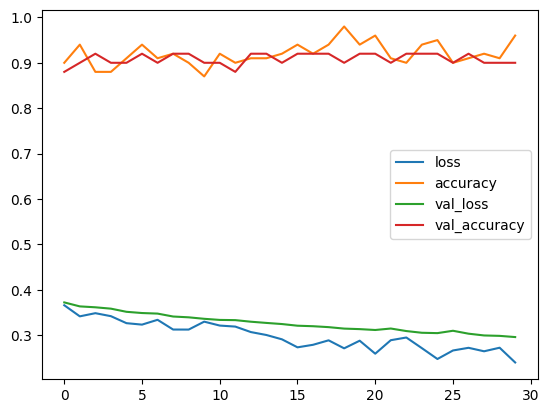

In [103]:
pd.DataFrame(eff_model_history.history).plot()

<h1>Testing</h1>
<p>Looking at the graph we are still underfitting but I am happy with the current model that I have so I will test my earlier (base) model and my newer model to see how well both of them do on the test set</p>

<h3>Basic Model</h3>

In [24]:
test_loss, test_acc = basic_model.evaluate(test_dataset)
test_acc

2/2 [==============================] - 1s 235ms/step - loss: 0.5982 - accuracy: 0.7200


0.7200000286102295

<h3>Efficient Model</h3>

In [104]:
test_loss, test_acc = eff_model.evaluate(test_dataset)
test_acc

2/2 [==============================] - 2s 764ms/step - loss: 0.2854 - accuracy: 0.8800


0.8799999952316284

<p>You might have different accuracy values due to the learning rate getting caught in a local minimum. I got 72% on the basic model and 88% on the Efficient Model at my time of running it.</p>

<h2>Save Model</h2>

In [106]:
eff_model.save("best_network.h5")

<h1>Evaluation</h1>
<p>Going from 62% accuracy to 88% when all I had to use was transfer learning is very impressive. Especially since I would say this classification is a more harder type of classification. Even with having a pretty low amount of examples I was able to create a decent model using transfer learning.</p>

<h1>Extra: (has nothing to do with transfer learning)</h1>

<h1>Image Processing using CV2</h1>

<p>So one of my ideas was to use image processing before feeding the image into the convolutional network. From looking at the difference between strawberries and raspberries you can see the texture is different. The light reflects off the fruit differently. There is a lot more white patches on the raspberry due to its reflection. If we can grab the red parts of the image and convert it to red then the network should be able to learn the difference between the textures. However, you would have to ensure that the image fed in is a strawberry or raspberry to make the guess, so assume I have a website that is called strawberryVSraspberry and it checks the differences.</p>

<p>Used <a href="https://stackoverflow.com/questions/30331944/finding-red-color-in-image-using-python-opencv">this</a> to get the red out of the image.</p>

> pip install opencv-python

In [27]:
import cv2

# Show the image, used to stop repetitive code
def show_image(title, image):
    plt.imshow(image)
    plt.title(title)
    plt.show()

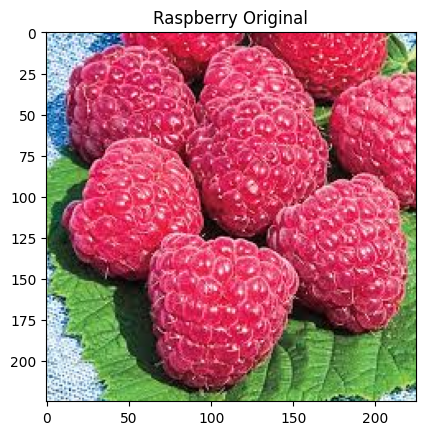

In [28]:
frame = cv2.imread('./train/raspberry/images (11).jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
show_image("Raspberry Original", frame)


<h2>Getting the red out of the image!</h2>
<ol>
    <li>Convert to HSV to brighten the colours</li>
    <li>Mask out the colour that is in between the lower red and upper red region.</li>
    <li>Mask out the colour between upper red and lower red of the spectrum.</li>
</ol>

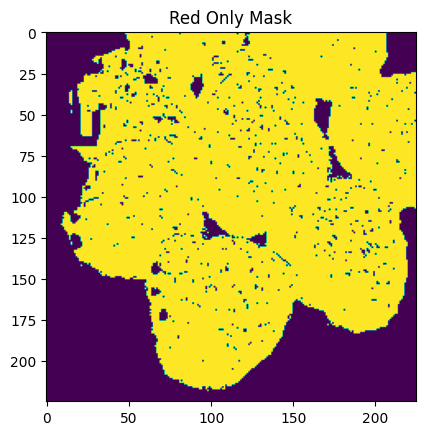

In [29]:
frame = cv2.imread('./train/raspberry/images (11).jpg')
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
lower_red = np.array([0,50,50])
upper_red = np.array([10,255,255])
mask0 = cv2.inRange(hsv, lower_red, upper_red)
lower_red = np.array([170,50,50])
upper_red = np.array([180,255,255])
mask1 = cv2.inRange(hsv, lower_red, upper_red)
show_image("Red Only Mask", mask0 + mask1)

In [30]:
edges = cv2.Canny(mask0 + mask1, 200, 400)

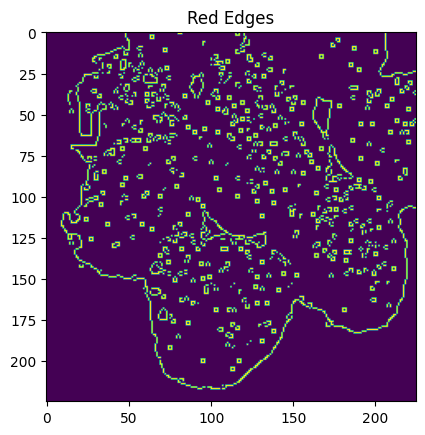

In [31]:
show_image("Red Edges", edges)

In [32]:
#Function to do all of it
def process_image(image):
    frame = cv2.imread(image)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(hsv, lower_red, upper_red)
    
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    
    edges = cv2.Canny(mask0 + mask1, 200, 400)
    
    return edges

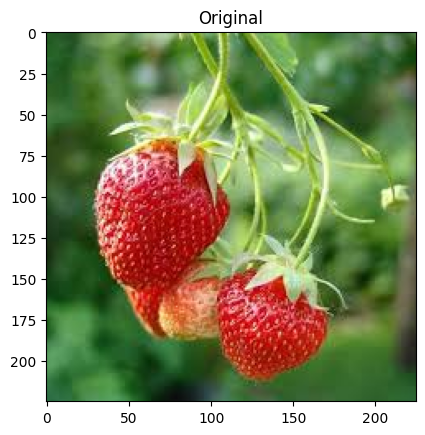

In [33]:
frame = cv2.imread('./train/strawberry/images (5).jpg')
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
show_image("Original", frame)

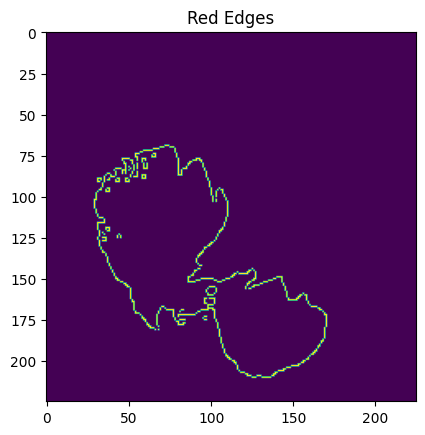

In [34]:
show_image("Red Edges", process_image('./train/strawberry/images (5).jpg'))

<h2>Difference between Strawberry and Raspberry Edges</h2>
<p>Now I will show the difference between them below!</p>

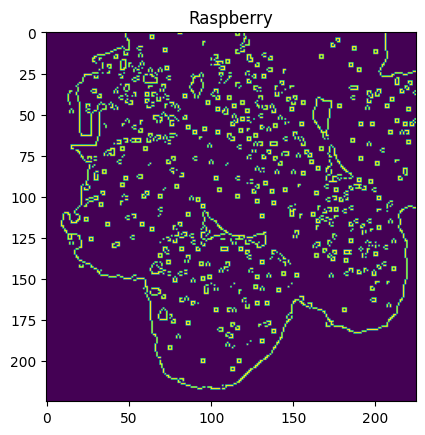

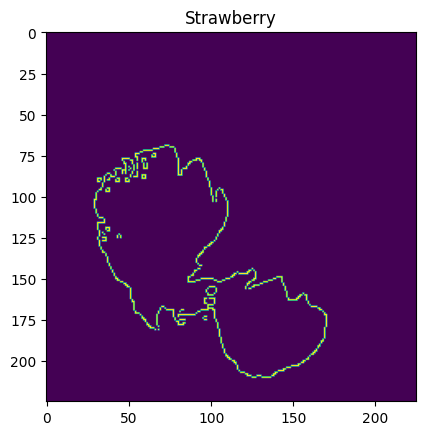

In [35]:
show_image("Raspberry", process_image('./train/raspberry/images (11).jpg'))
show_image("Strawberry", process_image('./train/strawberry/images (5).jpg'))

<h2>Big difference in the edges.</h2>
<p>This may or may not be practical but I thought it was a good idea to try help the network find dominant features that define whether it is a strawberry or raspberry.</p>
<p>However, it isn't going to work on transfer learning as it can't identify what this is</p>